# Imports

In [1]:
import os
os.chdir("D:\PulpitE\FPL_ML")

In [2]:
import pandas as pd

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np

# Data

In [3]:
df = pd.read_csv('data/fpl_fbref_players.csv')

In [4]:
info = ["Name"]
features = ["Min", "Gls", "Sh", "SoT", "xG", "npxG", "xAG", "CS", "Was Home"]
to_predict = ["FPL"]

In [5]:
df = df[info + features + to_predict]
df[features + to_predict] = df[features + to_predict].astype("float32")

In [6]:
df.shape

(6104, 11)

In [7]:
# removing NaN rows and players that appear less than 15 times
df = df.dropna()
grouped = df.groupby('Name')
df = grouped.filter(lambda x: len(x) >= 15)

In [8]:
df.shape

(4080, 11)

In [9]:
last_names = df["Name"].unique()

In [10]:
# for p in df["Name"].unique():
#     print (p, df[df["Name"] == p].shape)

In [11]:
# shifting
# df['FPL'] = df['FPL'].shift(-1)
# test_row = df[-1]
# df = df[:-1]

# DF to DataLoader

In [12]:
from torchvision.transforms import ToTensor

class PandasDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.names = dataframe["Name"].unique()
        self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        # print(idx)
        name = self.names[idx]
        # print(name)
        features = self.dataframe[self.dataframe["Name"] == name].drop(columns=["Name"]).values[:, :-1]
        # print(features)
        # print(type(features))
        # print(self.dataframe[self.dataframe["Name"] == name].values[:, -1])
        # print(type(self.dataframe[self.dataframe["Name"] == name].values[:, -1]))
        # target = self.dataframe[self.dataframe["Name"] == name].values[:, -1]
        # target = target.astype(np.float32)
        # target = torch.from_numpy(target)
        target = np.float32(self.dataframe[self.dataframe["Name"] == name].values[-1, -1])
        # print(type(target))
        return features, target

In [13]:
dataset = PandasDataset(df)
dataset.__getitem__(3)

(array([[90. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ],
        [90. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [90. ,  1. ,  2. ,  1. ,  0.1,  0.1,  0. ,  0. ,  0. ],
        [90. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ],
        [90. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  1. ],
        [90. ,  0. ,  1. ,  0. ,  0.1,  0.1,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  1. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ],
        [ 1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ],
        [90. ,  0. ,  1. ,  1. ,  0. ,  0. ,  0. ,  1. ,  0. ],
        [90. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ]],
       dtype=float32),
 2.0)

In [14]:
batch_size = 16

In [15]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [16]:
next(iter(dataloader))[1]

tensor([2., 2., 2., 2., 1., 2., 5., 2., 3., 2., 2., 2., 2., 2., 1., 1.])

# LSTM Model

In [17]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMNetwork, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x = torch.transpose(x, 0, 1)
        x = x.view(-1, batch_size)
        x = torch.transpose(x, 0, 1)
        # print(x.shape)
        # print(x.shape)
        out, _ = self.lstm(x)
        # print(out.shape)
        out = self.fc(out[-1])
        return out

In [18]:
len(dataloader)

17

In [19]:
torch.transpose(next(iter(dataloader))[0], 0, 1).shape

torch.Size([15, 16, 9])

In [20]:
net = LSTMNetwork(9 * 15, 20, 2, 1, dropout=0.2)

# Training loop

In [21]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.005)

In [25]:
num_epochs = 100
loss_history = []
for epoch in range(num_epochs):
    running_loss = 0
    for i, (inputs, targets) in enumerate(dataloader):
        # print(inputs.shape, targets.shape)
        # print(targets.shape)
        # print(targets)
        optimizer.zero_grad()
        outputs = net(inputs)
        print(outputs.shape)
        loss = criterion(outputs, targets)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    loss_history.append(running_loss / len(dataloader))
    if epoch % 5 == 0:
        print(f'Epoch {epoch} Loss: {running_loss / len(dataloader)}')

torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
Epoch 0 Loss: 3.539381938822129
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Size([1])
torch.Si

KeyboardInterrupt: 

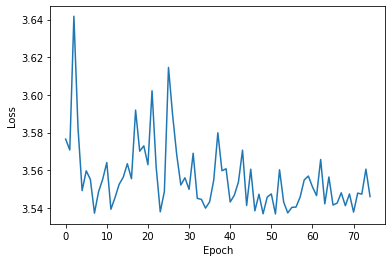

In [23]:
plt.plot(loss_history[25:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Predictions

In [24]:
# dataloader.batch_sampler.batch_size = 64
for name, (input, target) in zip (last_names, dataloader):
    output = net(input)
    print(output.item())
    print(name, round(output.item(), 2))

2.1698131561279297
Brenden-Aaronson 2.17
1.945796012878418
Che-Adams 1.95
2.6970770359039307
Tyler-Adams 2.7
1.5144240856170654
Tosin-Adarabioyo 1.51
2.0114307403564453
Rayan-Ait-Nouri 2.01
2.487121820449829
Marc-Albrighton 2.49
2.643252372741699
Trent-Alexander-Arnold 2.64
2.5671098232269287
Alisson 2.57
2.7641043663024902
Miguel-Almiron 2.76
2.758986234664917
Julian-Alvarez 2.76
2.6092875003814697
Daniel-Amartey 2.61
2.1107122898101807
Joachim-Andersen 2.11
2.677985906600952
Elliot-Anderson 2.68
2.3962178230285645
Jaidon-Anthony 2.4
2.4393420219421387
Michail-Antonio 2.44
2.721750020980835
Alphonse-Areola 2.72
2.331113815307617
Joe-Aribo 2.33
